<a href="https://colab.research.google.com/github/oopere/GANs/blob/main/C4_COND_GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4 - GAN Tutorial.
## Generate Mnist Images with a CONDITIONAL DCGAN.

In [1]:
#!pip install tensorflow==2.9.0
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

from keras.utils.vis_utils import plot_model

print (tf.__version__)

2.11.0


In [2]:
def plot_results(images, n_cols=None):
    '''visualizes fake images'''
    #display.clear_output(wait=False)  

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap = "binary")
        plt.axis("off")
    plt.show()

In [3]:
def load_dataset():
  # download the training images
  (X_train, y_train), (_, _) = keras.datasets.mnist.load_data()

  # normalize pixel values
  X_train = X_train.astype(np.float32) / 255

  # reshape and rescale
  X_train = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

  return [X_train, y_train]

In [4]:
def get_dataset_samples(dataset, n_samples):
  images, labels = dataset

  ix = np.random.randint(0, images.shape[0], n_samples)

  X, labels = images[ix], labels[ix]

  y = np.ones((n_samples, 1))
  return [X, labels], y

In [5]:
def generate_noise(noise_size, n_samples, n_classes=10):
  #generate noise
  x_input = np.random.randn(noise_size * n_samples)
  
  #shape to adjust to batch size
  z_input = x_input.reshape(n_samples, noise_size)

  #generate labels
  labels = np.random.randint(0, n_classes, n_samples)
  return [z_input, labels]



In [6]:
def generate_fake_samples(generator, latent_dim, n_samples): 
  #get the noise calling the function
  z_input, labels_input = generate_noise(latent_dim, n_samples)

  images = generator.predict([z_input, labels_input])

  #create class labes
  y = np.zeros((n_samples, 1))
  return [images, labels_input], y


In [7]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
  # label input
  in_label = keras.layers.Input(shape=(1,))
  # embedding for categorical input
  li = keras.layers.Embedding(n_classes, 50)(in_label)
  # linear multiplication
  n_nodes = 7 * 7
  li = keras.layers.Dense(n_nodes)(li)
  # reshape to additional channel
  li = keras.layers.Reshape((7, 7, 1))(li)
  # image generator input
  in_lat = keras.layers.Input(shape=(latent_dim,))
  # foundation for 7x7 image
  n_nodes = 128 * 7 * 7
  gen = keras.layers.Dense(n_nodes)(in_lat)

  gen = keras.layers.LeakyReLU(alpha=0.2)(gen)
  gen = keras.layers.Reshape((7, 7, 128))(gen)
  # merge image gen and label input
  merge = keras.layers.Concatenate()([gen, li])
  # upsample to 14x14
  gen = keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', 
                                     activation=keras.layers.LeakyReLU(alpha=0.2))(merge)
  gen = keras.layers.BatchNormalization()(gen)
  # upsample to 28x28
  gen = keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', 
                                     activation=keras.layers.LeakyReLU(alpha=0.2))(gen)
  gen = keras.layers.BatchNormalization()(gen)
  # output
  out_layer = keras.layers.Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
  # define model
  model = keras.Model([in_lat, in_label], out_layer)
  return model

In [8]:
noise_size = 50

generator = define_generator(noise_size)

generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 6272)         319872      ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_1[0][0]']                
                                                                                              

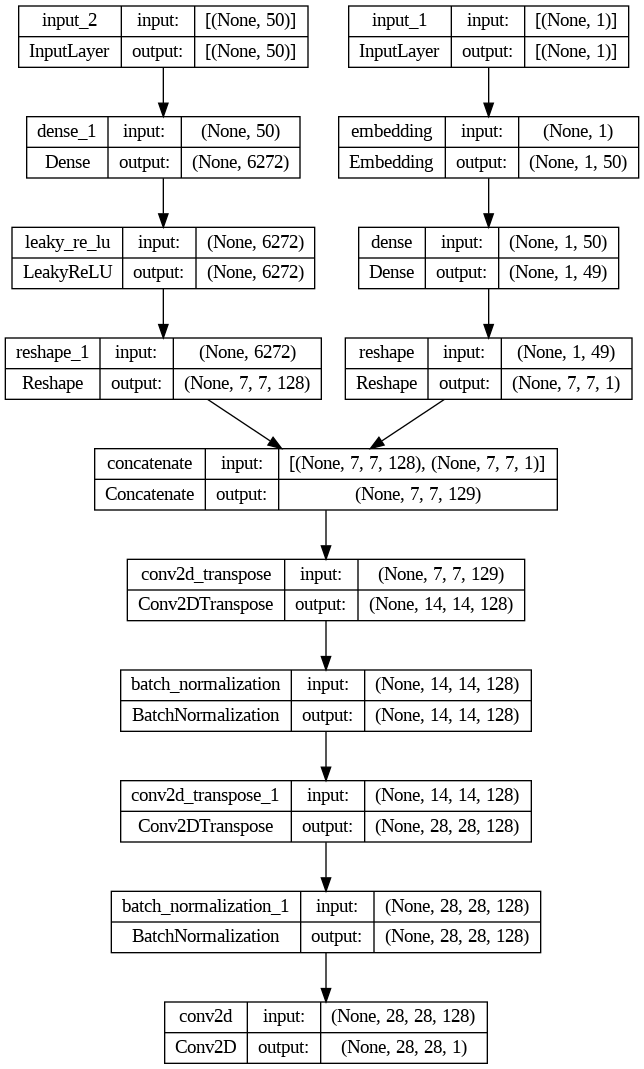

In [9]:
plot_model(generator, show_shapes=True, 
           show_layer_names=True)

In [10]:
def define_discriminator(in_shape=(28, 28, 1), n_classes=10):
  in_label = keras.layers.Input(shape=(1,))
  li = keras.layers.Embedding(n_classes, 50)(in_label)

  n_nodes = in_shape[0] * in_shape[1]
  li=keras.layers.Dense(n_nodes)(li)

  li=keras.layers.Reshape((in_shape[0], in_shape[1], 1))(li)

  in_image = keras.layers.Input(shape=in_shape)

  merge = keras.layers.Concatenate()([in_image, li])

  #downsample
  fe=keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', 
                         activation=keras.layers.LeakyReLU(alpha=0.2))(merge)
  fe=keras.layers.Dropout(0.4)(fe)

  #downsample
  fe=keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', 
                         activation=keras.layers.LeakyReLU(alpha=0.2))(fe)
  fe=keras.layers.Dropout(0.4)(fe)

  fe = keras.layers.Flatten()(fe)

  out_layer = keras.layers.Dense(1, activation='sigmoid')(fe)

  model = keras.Model([in_image, in_label], out_layer)

  opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  return model

                              

In [11]:
discriminator = define_discriminator()
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        500         ['input_3[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 1, 784)       39984       ['embedding_1[0][0]']            
                                                                                                  
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                            

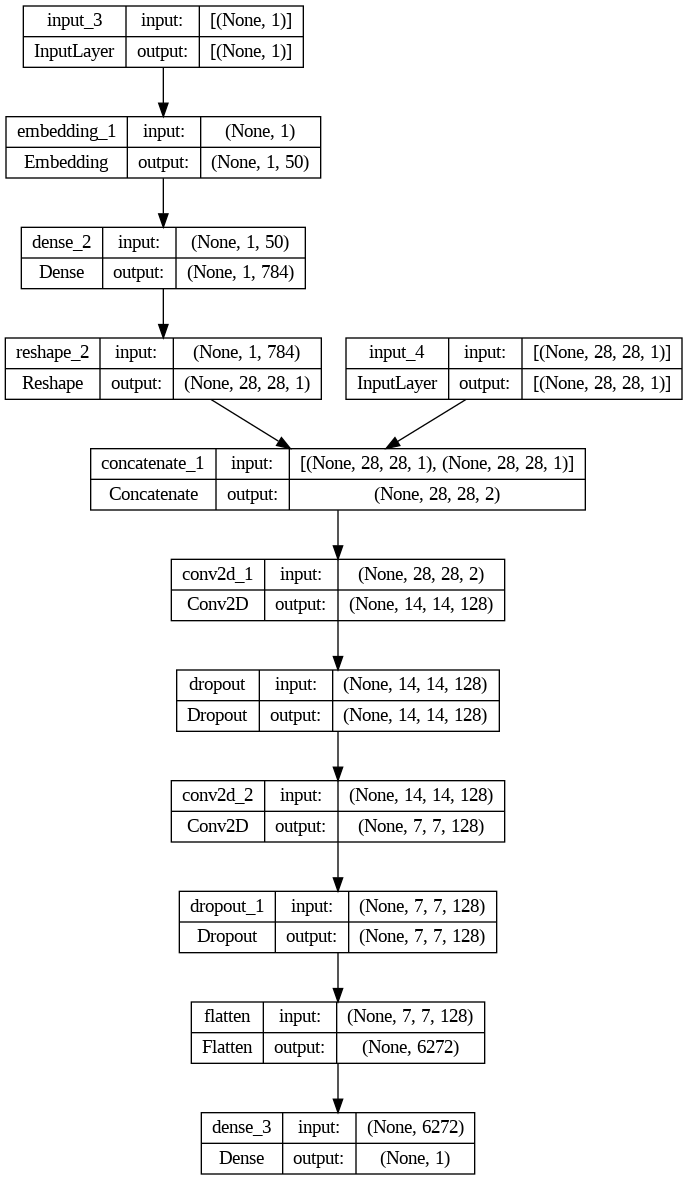

In [12]:
plot_model(discriminator, show_shapes=True, 
           show_layer_names=True)

In [13]:
#define the Conditional GAN
def define_gan(generator, discriminator):
  #make discriminator non trainable
  discriminator.trainable = False
  #get noise and label from generator
  gen_noise, gen_label = generator.input
  #get output from generator
  gen_output = generator.output

  #connect image and label input from generator as inputs to discriminator
  gan_output = discriminator([gen_output, gen_label])

  #define the GAN model. 
  model= keras.Model([gen_noise, gen_label], gan_output)

  #compile model
  opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model


In [14]:
GAN = define_gan(generator, discriminator)

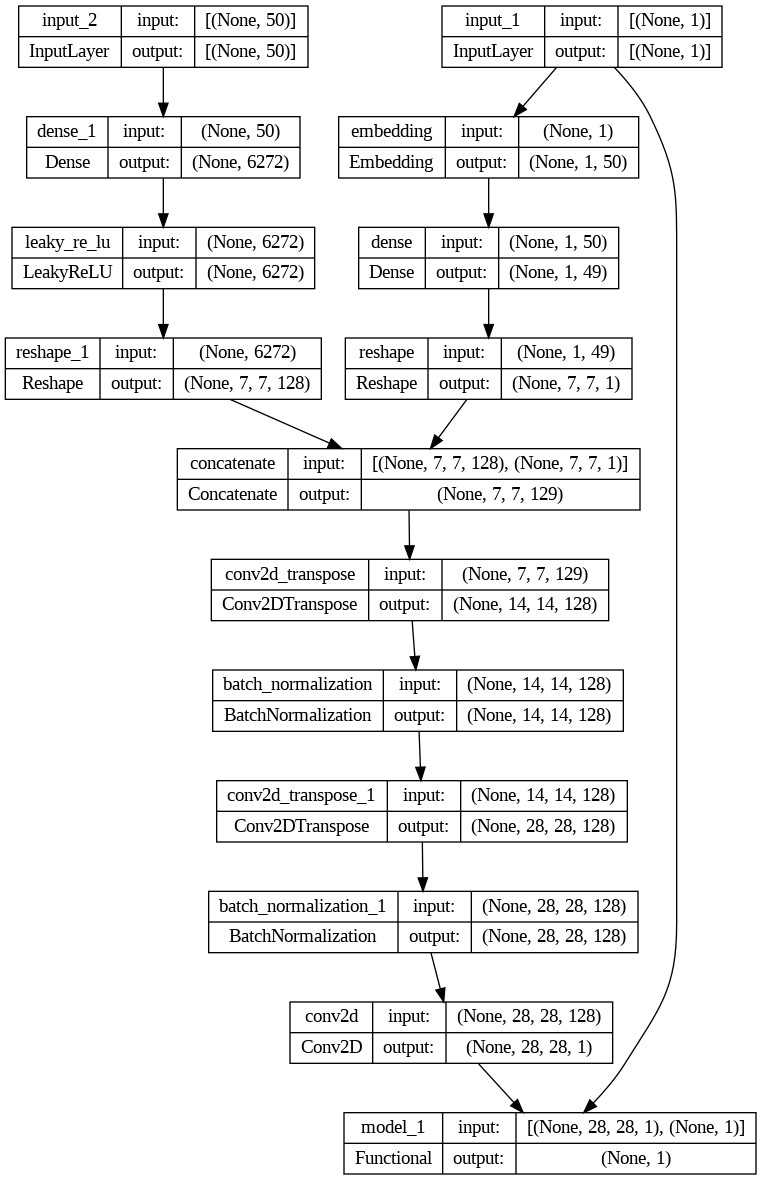

In [15]:
plot_model(GAN, show_shapes=True, 
           show_layer_names=True)

In [16]:
GAN.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 6272)         319872      ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_1[0][0]']                
                                                                                            

In [17]:
tf.keras.backend.clear_session()

In [18]:
def train_gan(generator, discriminator, GAN, dataset, noise_size=100, n_epochs=30, n_batch=512):
  steps = int(dataset[0].shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for e in range(n_epochs):
    # enumerate batches over the training set
    for s in range(steps):
      #TRAIN THE DISCRIMINATOR
      # get randomly selected 'real' samples
      [X_real, labels_real], y_real = get_dataset_samples(dataset, half_batch)
      # update discriminator model weights
      d_loss1, _ = discriminator.train_on_batch([X_real, labels_real], y_real)
      # generate 'fake' examples
      [X_fake, labels], y_fake = generate_fake_samples(generator, noise_size, half_batch)
      # update discriminator model weights
      d_loss2, _ = discriminator.train_on_batch([X_fake, labels], y_fake)

      #TRAIN THE GENERATOR
      # prepare points in latent space as input for the generator
      [z_input, labels_input] = generate_noise(noise_size, n_batch)
      # create inverted labels for the fake samples
      y_gan = np.ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = GAN.train_on_batch([z_input, labels_input], y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
      (e+1, s+1, steps, d_loss1, d_loss2, g_loss))
    plot_results(X_fake, 8)  
    
  # save the generator model
  generator.save('cgan_generator.h5')


In [19]:

dataset = load_dataset()


11490434/11490434 [==============================] - 2s 0us/step


2/2 [==============================] - 0s 6ms/step
>1, 1/468, d1=0.696, d2=0.697 g=0.734
2/2 [==============================] - 0s 6ms/step
>1, 2/468, d1=0.669, d2=0.720 g=0.745
2/2 [==============================] - 0s 6ms/step
>1, 3/468, d1=0.673, d2=0.690 g=0.716
2/2 [==============================] - 0s 5ms/step
>1, 4/468, d1=0.673, d2=0.705 g=0.719
2/2 [==============================] - 0s 7ms/step
>1, 5/468, d1=0.689, d2=0.674 g=0.737
2/2 [==============================] - 0s 6ms/step
>1, 6/468, d1=0.699, d2=0.691 g=0.750
2/2 [==============================] - 0s 6ms/step
>1, 7/468, d1=0.692, d2=0.684 g=0.771
2/2 [==============================] - 0s 6ms/step
>1, 8/468, d1=0.694, d2=0.671 g=0.728
2/2 [==============================] - 0s 5ms/step
>1, 9/468, d1=0.689, d2=0.662 g=0.737
2/2 [==============================] - 0s 6ms/step
>1, 10/468, d1=0.705, d2=0.669 g=0.728
2/2 [==============================] - 0s 6ms/step
>1, 11/468, d1=0.689, d2=0.680 g=0.734
2/2 [==============

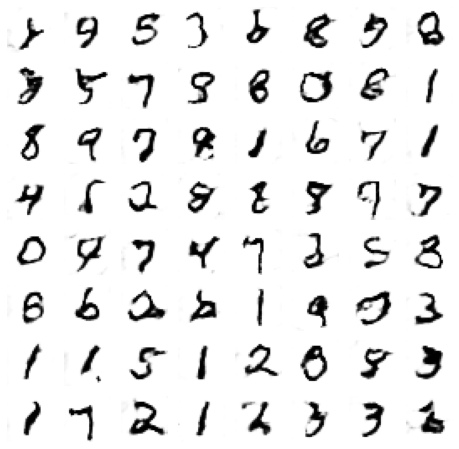

2/2 [==============================] - 0s 8ms/step
>2, 1/468, d1=0.663, d2=0.675 g=0.755
2/2 [==============================] - 0s 8ms/step
>2, 2/468, d1=0.690, d2=0.684 g=0.734
2/2 [==============================] - 0s 6ms/step
>2, 3/468, d1=0.651, d2=0.680 g=0.732
2/2 [==============================] - 0s 7ms/step
>2, 4/468, d1=0.689, d2=0.685 g=0.725
2/2 [==============================] - 0s 9ms/step
>2, 5/468, d1=0.712, d2=0.710 g=0.727
2/2 [==============================] - 0s 6ms/step
>2, 6/468, d1=0.666, d2=0.703 g=0.732
2/2 [==============================] - 0s 10ms/step
>2, 7/468, d1=0.681, d2=0.690 g=0.733
2/2 [==============================] - 0s 11ms/step
>2, 8/468, d1=0.670, d2=0.700 g=0.737
2/2 [==============================] - 0s 6ms/step
>2, 9/468, d1=0.681, d2=0.678 g=0.739
2/2 [==============================] - 0s 4ms/step
>2, 10/468, d1=0.693, d2=0.687 g=0.727
2/2 [==============================] - 0s 7ms/step
>2, 11/468, d1=0.671, d2=0.686 g=0.735
2/2 [============

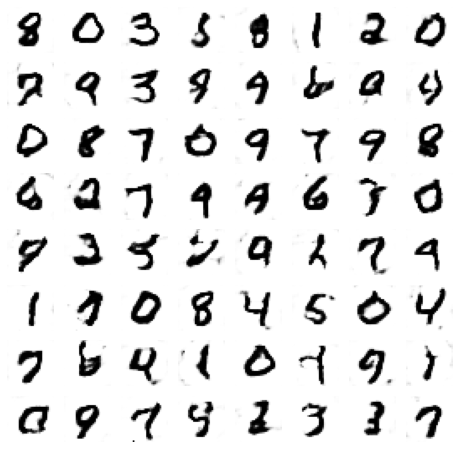

2/2 [==============================] - 0s 6ms/step
>3, 1/468, d1=0.681, d2=0.589 g=0.862
2/2 [==============================] - 0s 6ms/step
>3, 2/468, d1=0.703, d2=0.656 g=0.761
2/2 [==============================] - 0s 11ms/step
>3, 3/468, d1=0.696, d2=0.799 g=0.700
2/2 [==============================] - 0s 6ms/step
>3, 4/468, d1=0.665, d2=0.830 g=0.688
2/2 [==============================] - 0s 4ms/step
>3, 5/468, d1=0.693, d2=0.699 g=0.799
2/2 [==============================] - 0s 8ms/step
>3, 6/468, d1=0.678, d2=0.661 g=0.831
2/2 [==============================] - 0s 4ms/step
>3, 7/468, d1=0.670, d2=0.623 g=0.773
2/2 [==============================] - 0s 8ms/step
>3, 8/468, d1=0.639, d2=0.657 g=0.789
2/2 [==============================] - 0s 8ms/step
>3, 9/468, d1=0.677, d2=0.657 g=0.732
2/2 [==============================] - 0s 10ms/step
>3, 10/468, d1=0.678, d2=0.700 g=0.712
2/2 [==============================] - 0s 5ms/step
>3, 11/468, d1=0.680, d2=0.738 g=0.710
2/2 [============

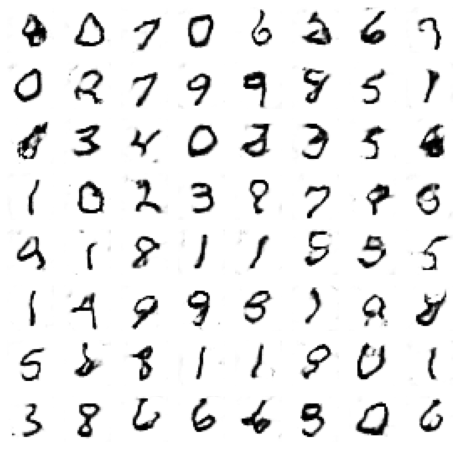

2/2 [==============================] - 0s 6ms/step
>4, 1/468, d1=0.675, d2=0.685 g=0.717
2/2 [==============================] - 0s 5ms/step
>4, 2/468, d1=0.706, d2=0.695 g=0.734
2/2 [==============================] - 0s 6ms/step
>4, 3/468, d1=0.678, d2=0.695 g=0.752
2/2 [==============================] - 0s 8ms/step
>4, 4/468, d1=0.652, d2=0.695 g=0.739
2/2 [==============================] - 0s 5ms/step
>4, 5/468, d1=0.666, d2=0.710 g=0.739
2/2 [==============================] - 0s 5ms/step
>4, 6/468, d1=0.660, d2=0.690 g=0.746
2/2 [==============================] - 0s 7ms/step
>4, 7/468, d1=0.659, d2=0.677 g=0.747
2/2 [==============================] - 0s 5ms/step
>4, 8/468, d1=0.672, d2=0.680 g=0.760
2/2 [==============================] - 0s 15ms/step
>4, 9/468, d1=0.703, d2=0.690 g=0.732
2/2 [==============================] - 0s 7ms/step
>4, 10/468, d1=0.671, d2=0.686 g=0.721
2/2 [==============================] - 0s 6ms/step
>4, 11/468, d1=0.670, d2=0.708 g=0.764
2/2 [=============

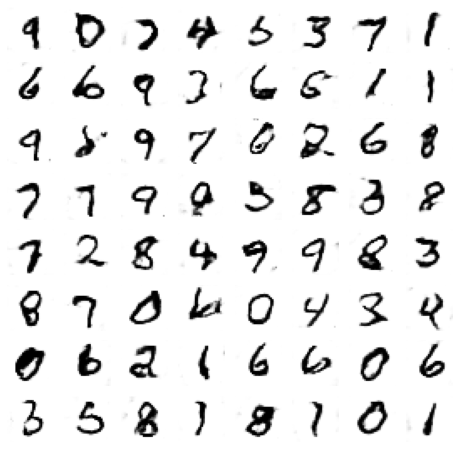

2/2 [==============================] - 0s 6ms/step
>5, 1/468, d1=0.727, d2=0.691 g=0.752
2/2 [==============================] - 0s 6ms/step
>5, 2/468, d1=0.661, d2=0.682 g=0.729
2/2 [==============================] - 0s 5ms/step
>5, 3/468, d1=0.690, d2=0.723 g=0.710
2/2 [==============================] - 0s 6ms/step
>5, 4/468, d1=0.681, d2=0.711 g=0.721
2/2 [==============================] - 0s 6ms/step
>5, 5/468, d1=0.710, d2=0.676 g=0.723
2/2 [==============================] - 0s 6ms/step
>5, 6/468, d1=0.680, d2=0.698 g=0.732
2/2 [==============================] - 0s 5ms/step
>5, 7/468, d1=0.684, d2=0.673 g=0.726
2/2 [==============================] - 0s 11ms/step
>5, 8/468, d1=0.681, d2=0.685 g=0.725
2/2 [==============================] - 0s 6ms/step
>5, 9/468, d1=0.684, d2=0.694 g=0.737
2/2 [==============================] - 0s 8ms/step
>5, 10/468, d1=0.675, d2=0.707 g=0.724
2/2 [==============================] - 0s 5ms/step
>5, 11/468, d1=0.721, d2=0.688 g=0.720
2/2 [=============

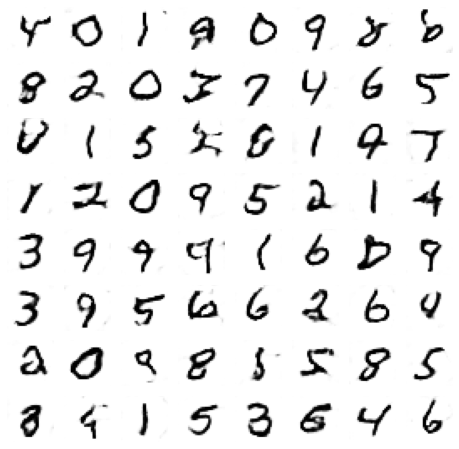

2/2 [==============================] - 0s 11ms/step
>6, 1/468, d1=0.681, d2=0.721 g=0.730
2/2 [==============================] - 0s 13ms/step
>6, 2/468, d1=0.636, d2=0.700 g=0.719
2/2 [==============================] - 0s 5ms/step
>6, 3/468, d1=0.654, d2=0.682 g=0.736
2/2 [==============================] - 0s 11ms/step
>6, 4/468, d1=0.679, d2=0.698 g=0.752
2/2 [==============================] - 0s 5ms/step
>6, 5/468, d1=0.672, d2=0.673 g=0.760
2/2 [==============================] - 0s 10ms/step
>6, 6/468, d1=0.682, d2=0.661 g=0.799
2/2 [==============================] - 0s 5ms/step
>6, 7/468, d1=0.691, d2=0.655 g=0.803
2/2 [==============================] - 0s 6ms/step
>6, 8/468, d1=0.668, d2=0.633 g=0.788
2/2 [==============================] - 0s 10ms/step
>6, 9/468, d1=0.718, d2=0.694 g=0.753
2/2 [==============================] - 0s 5ms/step
>6, 10/468, d1=0.684, d2=0.722 g=0.714
2/2 [==============================] - 0s 5ms/step
>6, 11/468, d1=0.711, d2=0.741 g=0.738
2/2 [=========

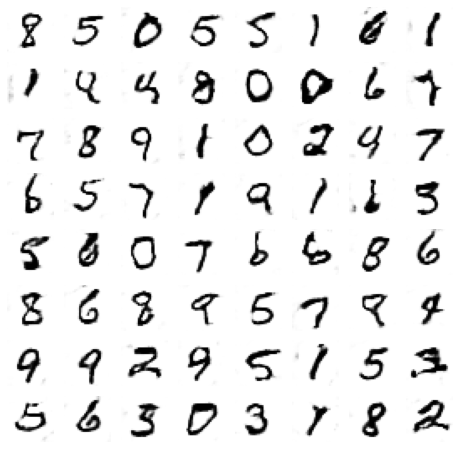

2/2 [==============================] - 0s 16ms/step
>7, 1/468, d1=0.675, d2=0.675 g=0.747
2/2 [==============================] - 0s 6ms/step
>7, 2/468, d1=0.712, d2=0.705 g=0.725
2/2 [==============================] - 0s 8ms/step
>7, 3/468, d1=0.656, d2=0.713 g=0.725
2/2 [==============================] - 0s 5ms/step
>7, 4/468, d1=0.681, d2=0.658 g=0.733
2/2 [==============================] - 0s 4ms/step
>7, 5/468, d1=0.710, d2=0.680 g=0.754
2/2 [==============================] - 0s 11ms/step
>7, 6/468, d1=0.661, d2=0.672 g=0.756
2/2 [==============================] - 0s 12ms/step
>7, 7/468, d1=0.711, d2=0.705 g=0.751
2/2 [==============================] - 0s 5ms/step
>7, 8/468, d1=0.692, d2=0.676 g=0.732
2/2 [==============================] - 0s 14ms/step
>7, 9/468, d1=0.700, d2=0.667 g=0.734
2/2 [==============================] - 0s 15ms/step
>7, 10/468, d1=0.717, d2=0.695 g=0.724
2/2 [==============================] - 0s 9ms/step
>7, 11/468, d1=0.684, d2=0.692 g=0.744
2/2 [=========

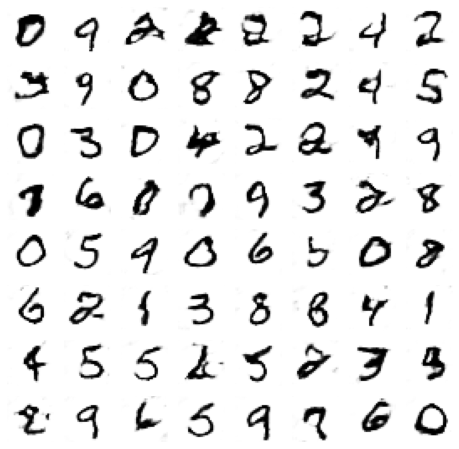

2/2 [==============================] - 0s 10ms/step
>8, 1/468, d1=0.668, d2=0.655 g=0.741
2/2 [==============================] - 0s 6ms/step
>8, 2/468, d1=0.699, d2=0.684 g=0.738
2/2 [==============================] - 0s 11ms/step
>8, 3/468, d1=0.686, d2=0.692 g=0.750
2/2 [==============================] - 0s 7ms/step
>8, 4/468, d1=0.690, d2=0.649 g=0.729
2/2 [==============================] - 0s 5ms/step
>8, 5/468, d1=0.681, d2=0.689 g=0.759
2/2 [==============================] - 0s 5ms/step
>8, 6/468, d1=0.694, d2=0.664 g=0.749
2/2 [==============================] - 0s 6ms/step
>8, 7/468, d1=0.707, d2=0.710 g=0.733
2/2 [==============================] - 0s 6ms/step
>8, 8/468, d1=0.669, d2=0.699 g=0.722
2/2 [==============================] - 0s 6ms/step
>8, 9/468, d1=0.671, d2=0.711 g=0.740
2/2 [==============================] - 0s 6ms/step
>8, 10/468, d1=0.701, d2=0.689 g=0.751
2/2 [==============================] - 0s 5ms/step
>8, 11/468, d1=0.714, d2=0.691 g=0.736
2/2 [============

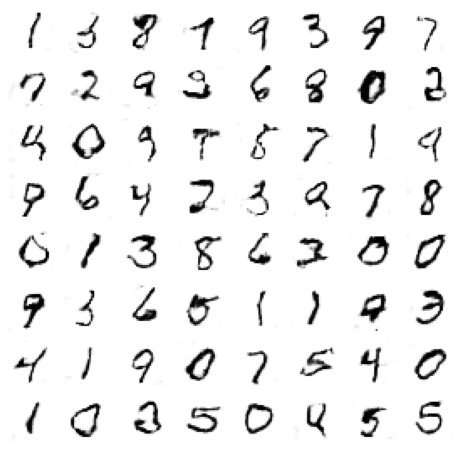

2/2 [==============================] - 0s 6ms/step
>9, 1/468, d1=0.693, d2=0.714 g=0.758
2/2 [==============================] - 0s 8ms/step
>9, 2/468, d1=0.673, d2=0.679 g=0.756
2/2 [==============================] - 0s 5ms/step
>9, 3/468, d1=0.682, d2=0.693 g=0.744
2/2 [==============================] - 0s 13ms/step
>9, 4/468, d1=0.672, d2=0.660 g=0.753
2/2 [==============================] - 0s 5ms/step
>9, 5/468, d1=0.663, d2=0.679 g=0.745
2/2 [==============================] - 0s 6ms/step
>9, 6/468, d1=0.684, d2=0.728 g=0.737
2/2 [==============================] - 0s 9ms/step
>9, 7/468, d1=0.696, d2=0.692 g=0.743
2/2 [==============================] - 0s 13ms/step
>9, 8/468, d1=0.684, d2=0.701 g=0.732
2/2 [==============================] - 0s 10ms/step
>9, 9/468, d1=0.686, d2=0.718 g=0.737
2/2 [==============================] - 0s 5ms/step
>9, 10/468, d1=0.686, d2=0.653 g=0.760
2/2 [==============================] - 0s 6ms/step
>9, 11/468, d1=0.687, d2=0.671 g=0.775
2/2 [===========

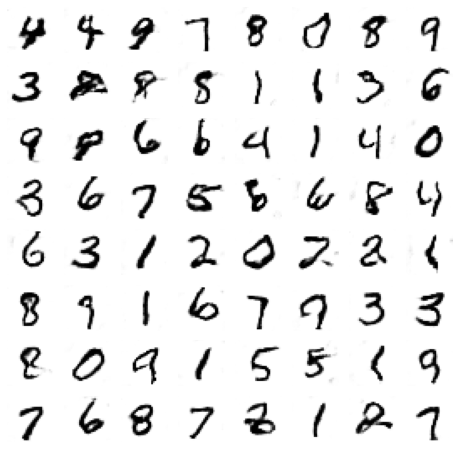

2/2 [==============================] - 0s 7ms/step
>10, 1/468, d1=0.690, d2=0.696 g=0.742
2/2 [==============================] - 0s 12ms/step
>10, 2/468, d1=0.686, d2=0.664 g=0.717
2/2 [==============================] - 0s 6ms/step
>10, 3/468, d1=0.714, d2=0.697 g=0.742
2/2 [==============================] - 0s 5ms/step
>10, 4/468, d1=0.679, d2=0.708 g=0.746
2/2 [==============================] - 0s 7ms/step
>10, 5/468, d1=0.689, d2=0.670 g=0.746
2/2 [==============================] - 0s 4ms/step
>10, 6/468, d1=0.681, d2=0.703 g=0.745
2/2 [==============================] - 0s 4ms/step
>10, 7/468, d1=0.684, d2=0.679 g=0.758
2/2 [==============================] - 0s 9ms/step
>10, 8/468, d1=0.685, d2=0.691 g=0.737
2/2 [==============================] - 0s 9ms/step
>10, 9/468, d1=0.687, d2=0.665 g=0.748
2/2 [==============================] - 0s 10ms/step
>10, 10/468, d1=0.697, d2=0.671 g=0.729
2/2 [==============================] - 0s 5ms/step
>10, 11/468, d1=0.682, d2=0.680 g=0.755
2/2 [=

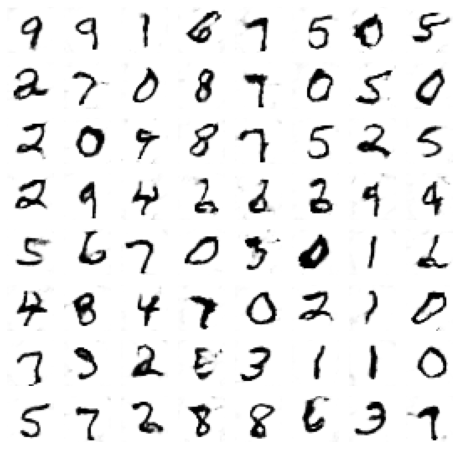

2/2 [==============================] - 0s 15ms/step
>11, 1/468, d1=0.660, d2=0.687 g=0.749
2/2 [==============================] - 0s 8ms/step
>11, 2/468, d1=0.673, d2=0.681 g=0.739
2/2 [==============================] - 0s 6ms/step
>11, 3/468, d1=0.676, d2=0.696 g=0.728
2/2 [==============================] - 0s 9ms/step
>11, 4/468, d1=0.687, d2=0.694 g=0.744
2/2 [==============================] - 0s 5ms/step
>11, 5/468, d1=0.669, d2=0.700 g=0.716
2/2 [==============================] - 0s 6ms/step
>11, 6/468, d1=0.697, d2=0.702 g=0.716
2/2 [==============================] - 0s 8ms/step
>11, 7/468, d1=0.684, d2=0.691 g=0.756
2/2 [==============================] - 0s 10ms/step
>11, 8/468, d1=0.675, d2=0.698 g=0.726
2/2 [==============================] - 0s 10ms/step
>11, 9/468, d1=0.695, d2=0.688 g=0.750
2/2 [==============================] - 0s 6ms/step
>11, 10/468, d1=0.677, d2=0.701 g=0.744
2/2 [==============================] - 0s 8ms/step
>11, 11/468, d1=0.657, d2=0.672 g=0.731
2/2 [

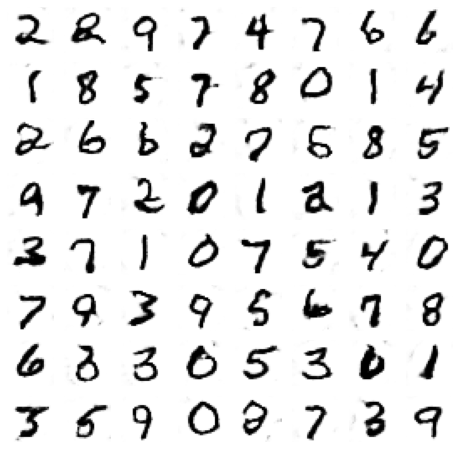

2/2 [==============================] - 0s 11ms/step
>12, 1/468, d1=0.673, d2=0.680 g=0.747
2/2 [==============================] - 0s 6ms/step
>12, 2/468, d1=0.694, d2=0.672 g=0.761
2/2 [==============================] - 0s 6ms/step
>12, 3/468, d1=0.682, d2=0.654 g=0.805
2/2 [==============================] - 0s 8ms/step
>12, 4/468, d1=0.701, d2=0.681 g=0.765
2/2 [==============================] - 0s 6ms/step
>12, 5/468, d1=0.685, d2=0.661 g=0.759
2/2 [==============================] - 0s 10ms/step
>12, 6/468, d1=0.692, d2=0.702 g=0.721
2/2 [==============================] - 0s 5ms/step
>12, 7/468, d1=0.709, d2=0.718 g=0.715
2/2 [==============================] - 0s 9ms/step
>12, 8/468, d1=0.683, d2=0.683 g=0.739
2/2 [==============================] - 0s 6ms/step
>12, 9/468, d1=0.682, d2=0.675 g=0.770
2/2 [==============================] - 0s 7ms/step
>12, 10/468, d1=0.669, d2=0.687 g=0.746
2/2 [==============================] - 0s 6ms/step
>12, 11/468, d1=0.672, d2=0.705 g=0.758
2/2 [=

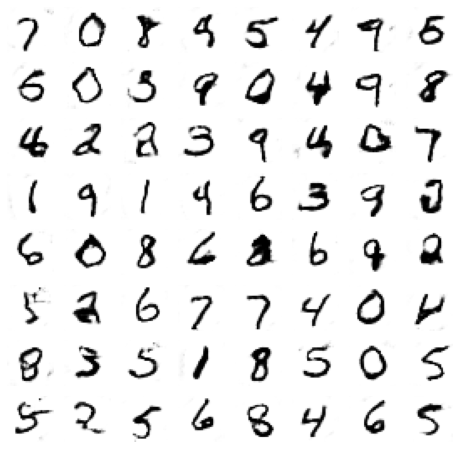

2/2 [==============================] - 0s 7ms/step
>13, 1/468, d1=0.725, d2=0.687 g=0.734
2/2 [==============================] - 0s 13ms/step
>13, 2/468, d1=0.667, d2=0.690 g=0.736
2/2 [==============================] - 0s 5ms/step
>13, 3/468, d1=0.684, d2=0.698 g=0.738
2/2 [==============================] - 0s 5ms/step
>13, 4/468, d1=0.690, d2=0.689 g=0.729
2/2 [==============================] - 0s 5ms/step
>13, 5/468, d1=0.667, d2=0.679 g=0.755
2/2 [==============================] - 0s 10ms/step
>13, 6/468, d1=0.710, d2=0.677 g=0.730
2/2 [==============================] - 0s 7ms/step
>13, 7/468, d1=0.663, d2=0.682 g=0.742
2/2 [==============================] - 0s 6ms/step
>13, 8/468, d1=0.657, d2=0.673 g=0.749
2/2 [==============================] - 0s 6ms/step
>13, 9/468, d1=0.675, d2=0.683 g=0.732
2/2 [==============================] - 0s 5ms/step
>13, 10/468, d1=0.670, d2=0.688 g=0.766
2/2 [==============================] - 0s 4ms/step
>13, 11/468, d1=0.695, d2=0.677 g=0.733
2/2 [=

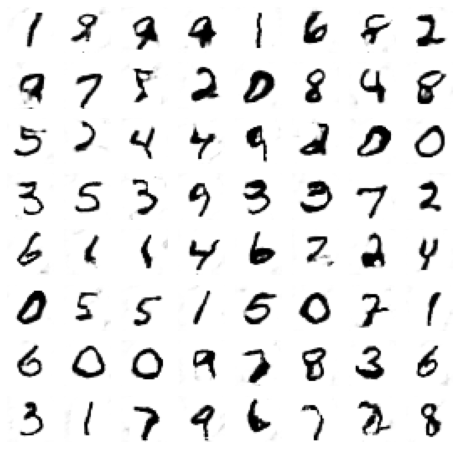

2/2 [==============================] - 0s 5ms/step
>14, 1/468, d1=0.689, d2=0.690 g=0.740
2/2 [==============================] - 0s 7ms/step
>14, 2/468, d1=0.689, d2=0.698 g=0.748
2/2 [==============================] - 0s 5ms/step
>14, 3/468, d1=0.716, d2=0.688 g=0.730
2/2 [==============================] - 0s 5ms/step
>14, 4/468, d1=0.680, d2=0.706 g=0.745
2/2 [==============================] - 0s 6ms/step
>14, 5/468, d1=0.695, d2=0.681 g=0.744
2/2 [==============================] - 0s 5ms/step
>14, 6/468, d1=0.683, d2=0.661 g=0.744
2/2 [==============================] - 0s 6ms/step
>14, 7/468, d1=0.683, d2=0.693 g=0.742
2/2 [==============================] - 0s 6ms/step
>14, 8/468, d1=0.675, d2=0.686 g=0.740
2/2 [==============================] - 0s 10ms/step
>14, 9/468, d1=0.706, d2=0.706 g=0.720
2/2 [==============================] - 0s 6ms/step
>14, 10/468, d1=0.693, d2=0.693 g=0.736
2/2 [==============================] - 0s 10ms/step
>14, 11/468, d1=0.696, d2=0.686 g=0.767
2/2 [=

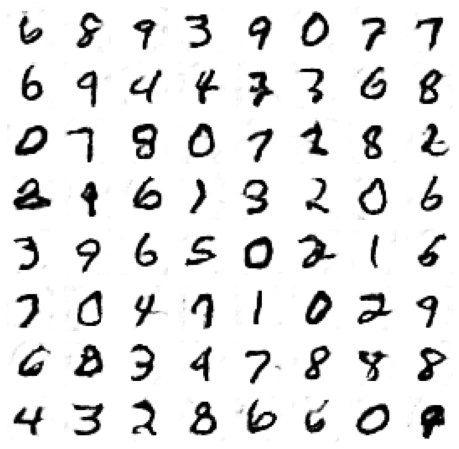

2/2 [==============================] - 0s 11ms/step
>15, 1/468, d1=0.705, d2=0.697 g=0.797
2/2 [==============================] - 0s 6ms/step
>15, 2/468, d1=0.695, d2=0.689 g=0.729
2/2 [==============================] - 0s 7ms/step
>15, 3/468, d1=0.707, d2=0.736 g=0.667
2/2 [==============================] - 0s 8ms/step
>15, 4/468, d1=0.713, d2=0.730 g=0.730
2/2 [==============================] - 0s 10ms/step
>15, 5/468, d1=0.678, d2=0.695 g=0.764
2/2 [==============================] - 0s 5ms/step
>15, 6/468, d1=0.675, d2=0.688 g=0.810
2/2 [==============================] - 0s 15ms/step
>15, 7/468, d1=0.650, d2=0.651 g=0.793
2/2 [==============================] - 0s 6ms/step
>15, 8/468, d1=0.678, d2=0.641 g=0.775
2/2 [==============================] - 0s 7ms/step
>15, 9/468, d1=0.674, d2=0.720 g=0.732
2/2 [==============================] - 0s 5ms/step
>15, 10/468, d1=0.689, d2=0.733 g=0.748
2/2 [==============================] - 0s 17ms/step
>15, 11/468, d1=0.662, d2=0.715 g=0.732
2/2 

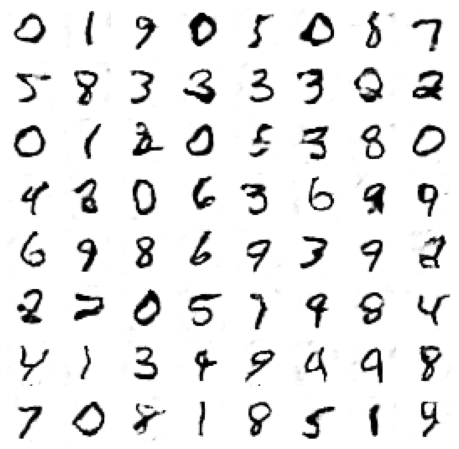

2/2 [==============================] - 0s 5ms/step
>16, 1/468, d1=0.692, d2=0.671 g=0.762
2/2 [==============================] - 0s 5ms/step
>16, 2/468, d1=0.661, d2=0.633 g=0.733
2/2 [==============================] - 0s 4ms/step
>16, 3/468, d1=0.705, d2=0.682 g=0.728
2/2 [==============================] - 0s 5ms/step
>16, 4/468, d1=0.712, d2=0.671 g=0.732
2/2 [==============================] - 0s 10ms/step
>16, 5/468, d1=0.681, d2=0.669 g=0.736
2/2 [==============================] - 0s 5ms/step
>16, 6/468, d1=0.682, d2=0.677 g=0.743
2/2 [==============================] - 0s 7ms/step
>16, 7/468, d1=0.664, d2=0.694 g=0.715
2/2 [==============================] - 0s 6ms/step
>16, 8/468, d1=0.678, d2=0.684 g=0.752
2/2 [==============================] - 0s 5ms/step
>16, 9/468, d1=0.707, d2=0.677 g=0.761
2/2 [==============================] - 0s 14ms/step
>16, 10/468, d1=0.693, d2=0.681 g=0.757
2/2 [==============================] - 0s 8ms/step
>16, 11/468, d1=0.676, d2=0.690 g=0.731
2/2 [=

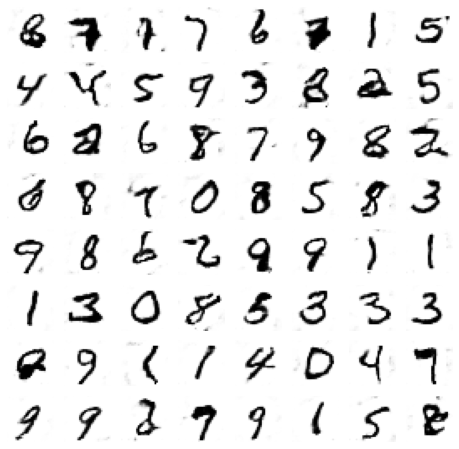

2/2 [==============================] - 0s 6ms/step
>17, 1/468, d1=0.686, d2=0.694 g=0.741
2/2 [==============================] - 0s 8ms/step
>17, 2/468, d1=0.698, d2=0.670 g=0.739
2/2 [==============================] - 0s 6ms/step
>17, 3/468, d1=0.709, d2=0.673 g=0.746
2/2 [==============================] - 0s 5ms/step
>17, 4/468, d1=0.714, d2=0.681 g=0.740
2/2 [==============================] - 0s 4ms/step
>17, 5/468, d1=0.668, d2=0.679 g=0.730
2/2 [==============================] - 0s 7ms/step
>17, 6/468, d1=0.673, d2=0.694 g=0.733
2/2 [==============================] - 0s 9ms/step
>17, 7/468, d1=0.674, d2=0.693 g=0.736
2/2 [==============================] - 0s 13ms/step
>17, 8/468, d1=0.686, d2=0.723 g=0.746
2/2 [==============================] - 0s 12ms/step
>17, 9/468, d1=0.680, d2=0.693 g=0.721
2/2 [==============================] - 0s 13ms/step
>17, 10/468, d1=0.687, d2=0.700 g=0.744
2/2 [==============================] - 0s 6ms/step
>17, 11/468, d1=0.677, d2=0.683 g=0.743
2/2 [

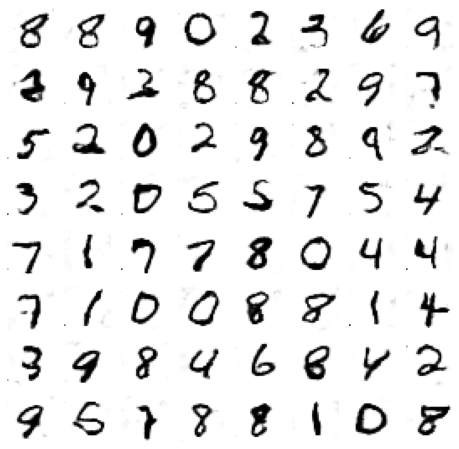

2/2 [==============================] - 0s 7ms/step
>18, 1/468, d1=0.679, d2=0.678 g=0.746
2/2 [==============================] - 0s 6ms/step
>18, 2/468, d1=0.699, d2=0.689 g=0.731
2/2 [==============================] - 0s 9ms/step
>18, 3/468, d1=0.679, d2=0.689 g=0.725
2/2 [==============================] - 0s 5ms/step
>18, 4/468, d1=0.724, d2=0.675 g=0.734
2/2 [==============================] - 0s 7ms/step
>18, 5/468, d1=0.700, d2=0.720 g=0.746
2/2 [==============================] - 0s 8ms/step
>18, 6/468, d1=0.700, d2=0.726 g=0.713
2/2 [==============================] - 0s 6ms/step
>18, 7/468, d1=0.674, d2=0.704 g=0.735
2/2 [==============================] - 0s 6ms/step
>18, 8/468, d1=0.685, d2=0.656 g=0.723
2/2 [==============================] - 0s 6ms/step
>18, 9/468, d1=0.689, d2=0.682 g=0.714
2/2 [==============================] - 0s 5ms/step
>18, 10/468, d1=0.666, d2=0.676 g=0.734
2/2 [==============================] - 0s 13ms/step
>18, 11/468, d1=0.657, d2=0.685 g=0.755
2/2 [==

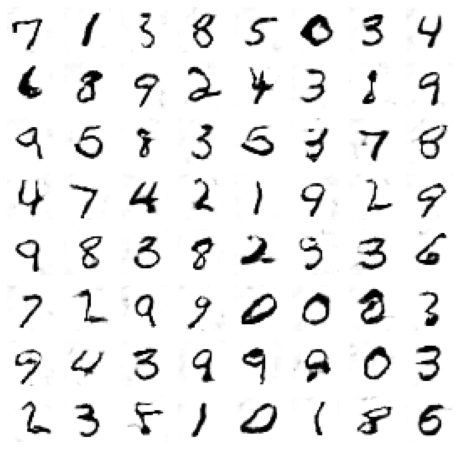

2/2 [==============================] - 0s 9ms/step
>19, 1/468, d1=0.717, d2=0.770 g=0.722
2/2 [==============================] - 0s 7ms/step
>19, 2/468, d1=0.690, d2=0.703 g=0.762
2/2 [==============================] - 0s 6ms/step
>19, 3/468, d1=0.679, d2=0.662 g=0.843
2/2 [==============================] - 0s 6ms/step
>19, 4/468, d1=0.696, d2=0.645 g=0.829
2/2 [==============================] - 0s 14ms/step
>19, 5/468, d1=0.713, d2=0.649 g=0.795
2/2 [==============================] - 0s 5ms/step
>19, 6/468, d1=0.712, d2=0.674 g=0.736
2/2 [==============================] - 0s 10ms/step
>19, 7/468, d1=0.661, d2=0.713 g=0.717
2/2 [==============================] - 0s 9ms/step
>19, 8/468, d1=0.711, d2=0.721 g=0.711
2/2 [==============================] - 0s 12ms/step
>19, 9/468, d1=0.673, d2=0.681 g=0.735
2/2 [==============================] - 0s 5ms/step
>19, 10/468, d1=0.657, d2=0.682 g=0.757
2/2 [==============================] - 0s 6ms/step
>19, 11/468, d1=0.693, d2=0.678 g=0.783
2/2 [

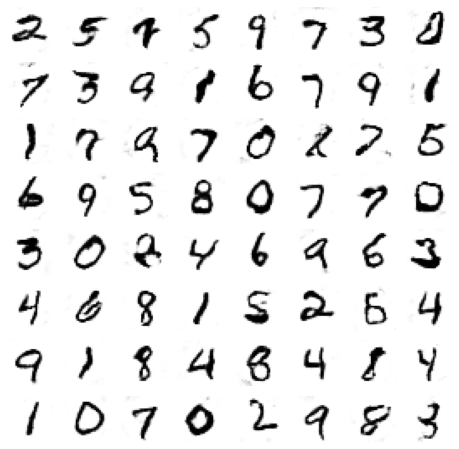

2/2 [==============================] - 0s 5ms/step
>20, 1/468, d1=0.698, d2=0.676 g=0.718
2/2 [==============================] - 0s 5ms/step
>20, 2/468, d1=0.704, d2=0.671 g=0.731
2/2 [==============================] - 0s 6ms/step
>20, 3/468, d1=0.692, d2=0.707 g=0.736
2/2 [==============================] - 0s 6ms/step
>20, 4/468, d1=0.682, d2=0.677 g=0.734
2/2 [==============================] - 0s 5ms/step
>20, 5/468, d1=0.665, d2=0.689 g=0.719
2/2 [==============================] - 0s 10ms/step
>20, 6/468, d1=0.679, d2=0.693 g=0.726
2/2 [==============================] - 0s 7ms/step
>20, 7/468, d1=0.671, d2=0.670 g=0.750
2/2 [==============================] - 0s 4ms/step
>20, 8/468, d1=0.652, d2=0.710 g=0.732
2/2 [==============================] - 0s 4ms/step
>20, 9/468, d1=0.696, d2=0.707 g=0.728
2/2 [==============================] - 0s 4ms/step
>20, 10/468, d1=0.712, d2=0.695 g=0.744
2/2 [==============================] - 0s 4ms/step
>20, 11/468, d1=0.684, d2=0.681 g=0.738
2/2 [==

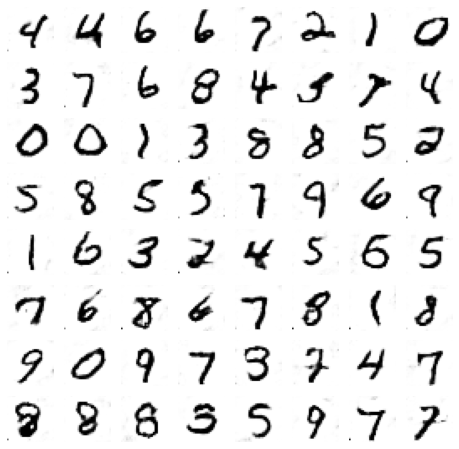

2/2 [==============================] - 0s 10ms/step
>21, 1/468, d1=0.681, d2=0.709 g=0.720
2/2 [==============================] - 0s 14ms/step
>21, 2/468, d1=0.687, d2=0.712 g=0.723
2/2 [==============================] - 0s 17ms/step
>21, 3/468, d1=0.689, d2=0.741 g=0.736
2/2 [==============================] - 0s 5ms/step
>21, 4/468, d1=0.674, d2=0.672 g=0.753
2/2 [==============================] - 0s 6ms/step
>21, 5/468, d1=0.689, d2=0.680 g=0.771
2/2 [==============================] - 0s 9ms/step
>21, 6/468, d1=0.688, d2=0.655 g=0.797
2/2 [==============================] - 0s 6ms/step
>21, 7/468, d1=0.687, d2=0.632 g=0.792
2/2 [==============================] - 0s 6ms/step
>21, 8/468, d1=0.703, d2=0.645 g=0.788
2/2 [==============================] - 0s 4ms/step
>21, 9/468, d1=0.708, d2=0.671 g=0.776
2/2 [==============================] - 0s 17ms/step
>21, 10/468, d1=0.682, d2=0.739 g=0.722
2/2 [==============================] - 0s 8ms/step
>21, 11/468, d1=0.681, d2=0.744 g=0.720
2/2 

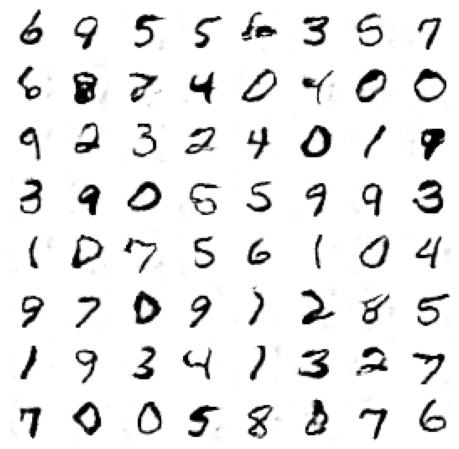

2/2 [==============================] - 0s 14ms/step
>22, 1/468, d1=0.665, d2=0.692 g=0.771
2/2 [==============================] - 0s 8ms/step
>22, 2/468, d1=0.672, d2=0.683 g=0.746
2/2 [==============================] - 0s 6ms/step
>22, 3/468, d1=0.674, d2=0.683 g=0.756
2/2 [==============================] - 0s 14ms/step
>22, 4/468, d1=0.684, d2=0.696 g=0.706
2/2 [==============================] - 0s 6ms/step
>22, 5/468, d1=0.670, d2=0.698 g=0.728
2/2 [==============================] - 0s 15ms/step
>22, 6/468, d1=0.674, d2=0.693 g=0.744
2/2 [==============================] - 0s 7ms/step
>22, 7/468, d1=0.683, d2=0.686 g=0.730
2/2 [==============================] - 0s 11ms/step
>22, 8/468, d1=0.693, d2=0.676 g=0.735
2/2 [==============================] - 0s 4ms/step
>22, 9/468, d1=0.683, d2=0.689 g=0.731
2/2 [==============================] - 0s 4ms/step
>22, 10/468, d1=0.651, d2=0.684 g=0.744
2/2 [==============================] - 0s 9ms/step
>22, 11/468, d1=0.665, d2=0.677 g=0.746
2/2 

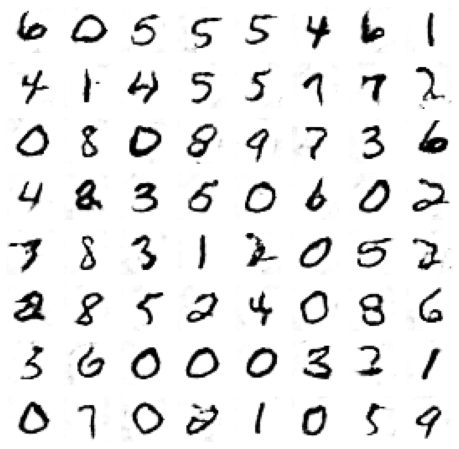

2/2 [==============================] - 0s 6ms/step
>23, 1/468, d1=0.674, d2=0.695 g=0.749
2/2 [==============================] - 0s 5ms/step
>23, 2/468, d1=0.655, d2=0.685 g=0.722
2/2 [==============================] - 0s 5ms/step
>23, 3/468, d1=0.698, d2=0.695 g=0.741
2/2 [==============================] - 0s 6ms/step
>23, 4/468, d1=0.676, d2=0.704 g=0.776
2/2 [==============================] - 0s 9ms/step
>23, 5/468, d1=0.667, d2=0.695 g=0.764
2/2 [==============================] - 0s 7ms/step
>23, 6/468, d1=0.672, d2=0.642 g=0.769
2/2 [==============================] - 0s 6ms/step
>23, 7/468, d1=0.723, d2=0.678 g=0.766
2/2 [==============================] - 0s 12ms/step
>23, 8/468, d1=0.695, d2=0.664 g=0.741
2/2 [==============================] - 0s 7ms/step
>23, 9/468, d1=0.673, d2=0.651 g=0.777
2/2 [==============================] - 0s 13ms/step
>23, 10/468, d1=0.679, d2=0.713 g=0.727
2/2 [==============================] - 0s 6ms/step
>23, 11/468, d1=0.680, d2=0.707 g=0.738
2/2 [=

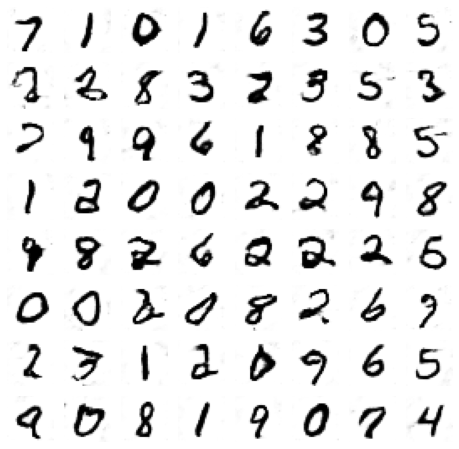

2/2 [==============================] - 0s 8ms/step
>24, 1/468, d1=0.675, d2=0.660 g=0.735
2/2 [==============================] - 0s 11ms/step
>24, 2/468, d1=0.698, d2=0.674 g=0.759
2/2 [==============================] - 0s 6ms/step
>24, 3/468, d1=0.688, d2=0.663 g=0.767
2/2 [==============================] - 0s 8ms/step
>24, 4/468, d1=0.688, d2=0.653 g=0.743
2/2 [==============================] - 0s 6ms/step
>24, 5/468, d1=0.681, d2=0.689 g=0.752
2/2 [==============================] - 0s 5ms/step
>24, 6/468, d1=0.692, d2=0.696 g=0.751
2/2 [==============================] - 0s 9ms/step
>24, 7/468, d1=0.701, d2=0.670 g=0.751
2/2 [==============================] - 0s 5ms/step
>24, 8/468, d1=0.696, d2=0.699 g=0.724
2/2 [==============================] - 0s 14ms/step
>24, 9/468, d1=0.720, d2=0.677 g=0.721
2/2 [==============================] - 0s 5ms/step
>24, 10/468, d1=0.700, d2=0.697 g=0.741
2/2 [==============================] - 0s 6ms/step
>24, 11/468, d1=0.679, d2=0.676 g=0.740
2/2 [=

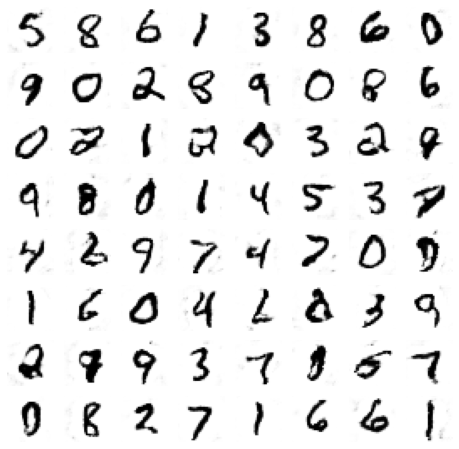

2/2 [==============================] - 0s 12ms/step
>25, 1/468, d1=0.696, d2=0.711 g=0.735
2/2 [==============================] - 0s 5ms/step
>25, 2/468, d1=0.655, d2=0.728 g=0.713
2/2 [==============================] - 0s 5ms/step
>25, 3/468, d1=0.641, d2=0.732 g=0.694
2/2 [==============================] - 0s 5ms/step
>25, 4/468, d1=0.691, d2=0.710 g=0.750
2/2 [==============================] - 0s 5ms/step
>25, 5/468, d1=0.676, d2=0.657 g=0.753
2/2 [==============================] - 0s 6ms/step
>25, 6/468, d1=0.701, d2=0.683 g=0.787
2/2 [==============================] - 0s 6ms/step
>25, 7/468, d1=0.696, d2=0.668 g=0.776
2/2 [==============================] - 0s 12ms/step
>25, 8/468, d1=0.679, d2=0.664 g=0.747
2/2 [==============================] - 0s 6ms/step
>25, 9/468, d1=0.667, d2=0.720 g=0.729
2/2 [==============================] - 0s 8ms/step
>25, 10/468, d1=0.660, d2=0.716 g=0.711
2/2 [==============================] - 0s 6ms/step
>25, 11/468, d1=0.649, d2=0.705 g=0.740
2/2 [=

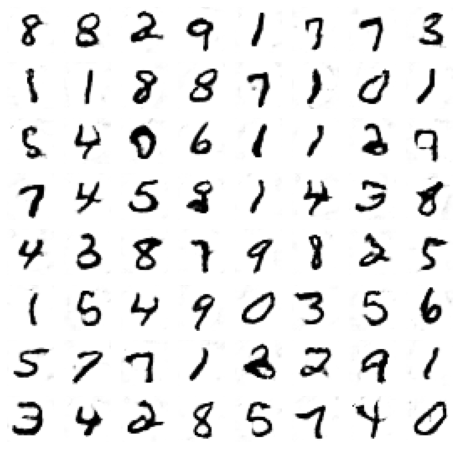

2/2 [==============================] - 0s 9ms/step
>26, 1/468, d1=0.701, d2=0.698 g=0.747
2/2 [==============================] - 0s 8ms/step
>26, 2/468, d1=0.706, d2=0.694 g=0.754
2/2 [==============================] - 0s 6ms/step
>26, 3/468, d1=0.699, d2=0.682 g=0.744
2/2 [==============================] - 0s 6ms/step
>26, 4/468, d1=0.672, d2=0.654 g=0.767
2/2 [==============================] - 0s 7ms/step
>26, 5/468, d1=0.674, d2=0.658 g=0.796
2/2 [==============================] - 0s 8ms/step
>26, 6/468, d1=0.659, d2=0.674 g=0.796
2/2 [==============================] - 0s 14ms/step
>26, 7/468, d1=0.695, d2=0.679 g=0.764
2/2 [==============================] - 0s 8ms/step
>26, 8/468, d1=0.664, d2=0.735 g=0.714
2/2 [==============================] - 0s 12ms/step
>26, 9/468, d1=0.704, d2=0.738 g=0.708
2/2 [==============================] - 0s 9ms/step
>26, 10/468, d1=0.688, d2=0.709 g=0.771
2/2 [==============================] - 0s 10ms/step
>26, 11/468, d1=0.695, d2=0.658 g=0.793
2/2 [

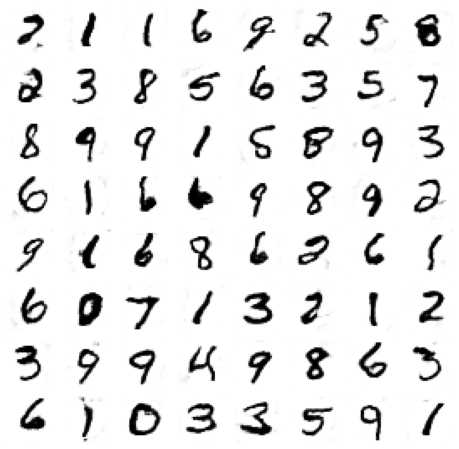

2/2 [==============================] - 0s 6ms/step
>27, 1/468, d1=0.670, d2=0.671 g=0.743
2/2 [==============================] - 0s 13ms/step
>27, 2/468, d1=0.672, d2=0.676 g=0.754
2/2 [==============================] - 0s 10ms/step
>27, 3/468, d1=0.712, d2=0.654 g=0.763
2/2 [==============================] - 0s 5ms/step
>27, 4/468, d1=0.697, d2=0.666 g=0.730
2/2 [==============================] - 0s 5ms/step
>27, 5/468, d1=0.688, d2=0.707 g=0.727
2/2 [==============================] - 0s 4ms/step
>27, 6/468, d1=0.664, d2=0.682 g=0.754
2/2 [==============================] - 0s 8ms/step
>27, 7/468, d1=0.652, d2=0.656 g=0.737
2/2 [==============================] - 0s 6ms/step
>27, 8/468, d1=0.659, d2=0.709 g=0.698
2/2 [==============================] - 0s 5ms/step
>27, 9/468, d1=0.688, d2=0.701 g=0.740
2/2 [==============================] - 0s 7ms/step
>27, 10/468, d1=0.667, d2=0.698 g=0.740
2/2 [==============================] - 0s 6ms/step
>27, 11/468, d1=0.670, d2=0.669 g=0.761
2/2 [=

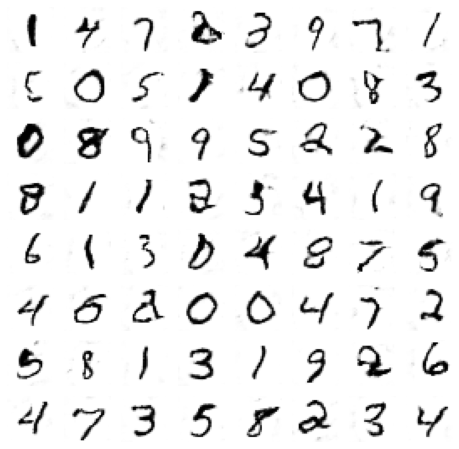

2/2 [==============================] - 0s 6ms/step
>28, 1/468, d1=0.683, d2=0.643 g=0.784
2/2 [==============================] - 0s 9ms/step
>28, 2/468, d1=0.668, d2=0.645 g=0.778
2/2 [==============================] - 0s 9ms/step
>28, 3/468, d1=0.706, d2=0.677 g=0.727
2/2 [==============================] - 0s 9ms/step
>28, 4/468, d1=0.683, d2=0.694 g=0.719
2/2 [==============================] - 0s 7ms/step
>28, 5/468, d1=0.699, d2=0.737 g=0.743
2/2 [==============================] - 0s 8ms/step
>28, 6/468, d1=0.672, d2=0.700 g=0.745
2/2 [==============================] - 0s 7ms/step
>28, 7/468, d1=0.638, d2=0.679 g=0.753
2/2 [==============================] - 0s 7ms/step
>28, 8/468, d1=0.628, d2=0.668 g=0.789
2/2 [==============================] - 0s 6ms/step
>28, 9/468, d1=0.697, d2=0.700 g=0.737
2/2 [==============================] - 0s 5ms/step
>28, 10/468, d1=0.695, d2=0.659 g=0.803
2/2 [==============================] - 0s 5ms/step
>28, 11/468, d1=0.637, d2=0.649 g=0.785
2/2 [===

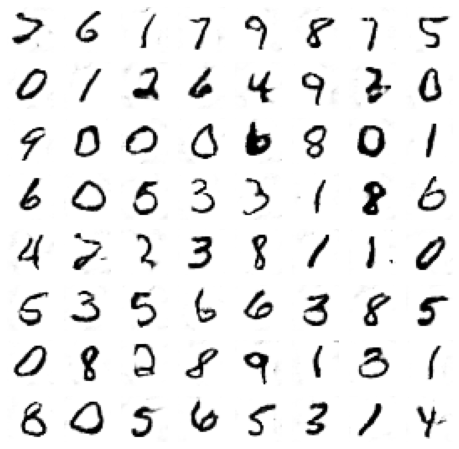

2/2 [==============================] - 0s 5ms/step
>29, 1/468, d1=0.648, d2=0.717 g=0.726
2/2 [==============================] - 0s 6ms/step
>29, 2/468, d1=0.672, d2=0.697 g=0.750
2/2 [==============================] - 0s 5ms/step
>29, 3/468, d1=0.683, d2=0.671 g=0.756
2/2 [==============================] - 0s 6ms/step
>29, 4/468, d1=0.700, d2=0.694 g=0.737
2/2 [==============================] - 0s 6ms/step
>29, 5/468, d1=0.679, d2=0.690 g=0.751
2/2 [==============================] - 0s 9ms/step
>29, 6/468, d1=0.698, d2=0.669 g=0.752
2/2 [==============================] - 0s 6ms/step
>29, 7/468, d1=0.699, d2=0.687 g=0.739
2/2 [==============================] - 0s 6ms/step
>29, 8/468, d1=0.696, d2=0.710 g=0.741
2/2 [==============================] - 0s 7ms/step
>29, 9/468, d1=0.677, d2=0.691 g=0.745
2/2 [==============================] - 0s 7ms/step
>29, 10/468, d1=0.663, d2=0.687 g=0.729
2/2 [==============================] - 0s 7ms/step
>29, 11/468, d1=0.665, d2=0.696 g=0.727
2/2 [===

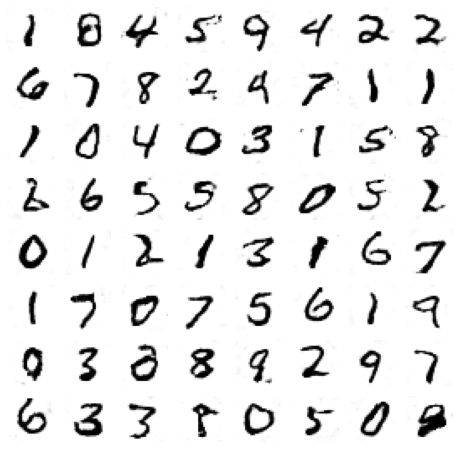

2/2 [==============================] - 0s 6ms/step
>30, 1/468, d1=0.678, d2=0.680 g=0.772
2/2 [==============================] - 0s 6ms/step
>30, 2/468, d1=0.694, d2=0.692 g=0.750
2/2 [==============================] - 0s 7ms/step
>30, 3/468, d1=0.666, d2=0.680 g=0.751
2/2 [==============================] - 0s 7ms/step
>30, 4/468, d1=0.694, d2=0.678 g=0.737
2/2 [==============================] - 0s 7ms/step
>30, 5/468, d1=0.702, d2=0.674 g=0.727
2/2 [==============================] - 0s 10ms/step
>30, 6/468, d1=0.674, d2=0.689 g=0.761
2/2 [==============================] - 0s 6ms/step
>30, 7/468, d1=0.676, d2=0.670 g=0.748
2/2 [==============================] - 0s 5ms/step
>30, 8/468, d1=0.674, d2=0.679 g=0.745
2/2 [==============================] - 0s 7ms/step
>30, 9/468, d1=0.684, d2=0.658 g=0.778
2/2 [==============================] - 0s 6ms/step
>30, 10/468, d1=0.681, d2=0.680 g=0.750
2/2 [==============================] - 0s 6ms/step
>30, 11/468, d1=0.659, d2=0.682 g=0.740
2/2 [==

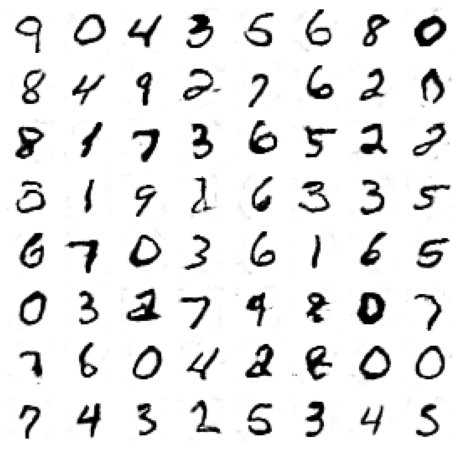

In [22]:
train_gan(generator, discriminator, GAN, dataset, noise_size, n_epochs=30, n_batch=128)

1/1 [==============================] - 0s 177ms/step


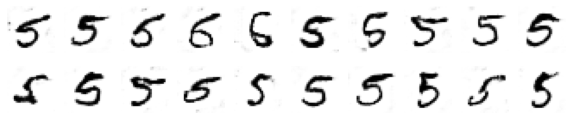

1/1 [==============================] - 0s 30ms/step


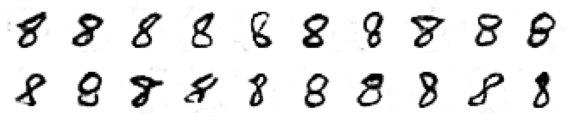

In [28]:
#Test de Conditional Generator. 
model = keras.models.load_model('cgan_generator.h5')

latent_points, labels = generate_noise(noise_size, 20)
labels = np.ones(20) * 5
X = model.predict([latent_points, labels])
plot_results(X, 10)

labels = np.ones(20) * 8
X = model.predict([latent_points, labels])
plot_results(X, 10)